In [4]:
#Done on Kaggle since GPU usage available.



# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1269.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1385.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1383.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1354.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1339.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1380.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1304.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1340.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1211.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1355.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1222.jpg
/kaggle/input/vegetable-image-dataset/Vegetable Images/validation/Broccoli/1

Problem Statement
Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.


In [5]:


import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed



In [6]:
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()
    
def testAccuracy(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    predicted_categories = tf.argmax(y_pred, axis=1)
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')
    
def plot_image(pred_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                ),
                                color=color)

def predictions(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 15)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(4*num_cols, 2*num_rows))
    for i,index in enumerate(indices):
      plt.subplot(num_rows, num_cols, i+1)
      plot_image(y_pred[index], true_categories[index], images[index],class_names)
    plt.tight_layout()
    plt.show()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("final_model.h5", save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5, restore_best_weights=True
)

In [7]:
class_dirs = os.listdir("/kaggle/input/vegetable-image-dataset/Vegetable Images/train") # list all directories inside "train" folder

image_dict = {} # dict to store image array(key) for every class(value)

count_dict = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'../input/vegetable-image-dataset/Vegetable Images/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

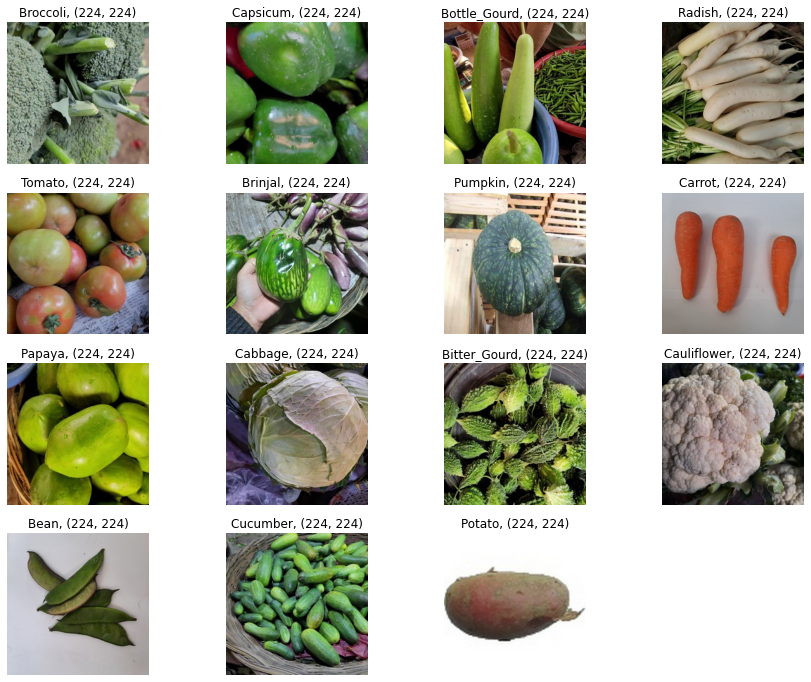

In [8]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    # create a subplot axis
    ax = plt.subplot(4, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

In [10]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

Count of training samples per class:
            class  count
0       Broccoli   1000
1       Capsicum   1000
2   Bottle_Gourd   1000
3         Radish   1000
4         Tomato   1000
5        Brinjal   1000
6        Pumpkin   1000
7         Carrot   1000
8         Papaya   1000
9        Cabbage   1000
10  Bitter_Gourd   1000
11   Cauliflower   1000
12          Bean   1000
13      Cucumber   1000
14        Potato   1000


<Figure size 1080x864 with 0 Axes>

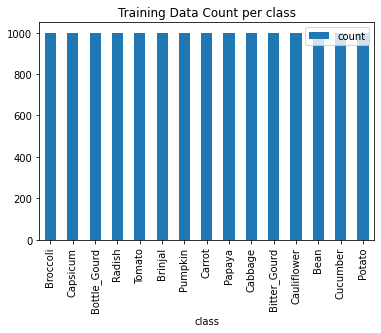

In [11]:
# draw a bar plot using pandas in-built plotting function
plt.figure(figsize=(15,12))
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class") 
plt.show()


Loading data set

In [12]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/vegetable-image-dataset/Vegetable Images/train", shuffle = False,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/vegetable-image-dataset/Vegetable Images/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/vegetable-image-dataset/Vegetable Images/test", shuffle = False,
)



Loading Train Data...
Found 15000 files belonging to 15 classes.


2023-01-06 09:29:45.894313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 09:29:45.895354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 09:29:46.086057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 09:29:46.087659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 09:29:46.089140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S


Loading Validation Data...
Found 3000 files belonging to 15 classes.

Loading Test Data...
Found 3000 files belonging to 15 classes.


Data Preprocessing

In [13]:
height, width = 224, 224

# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))



In [14]:
num_classes = 15
hidden_size_1 = 1024
hidden_size_2 = 256
hidden_size_3 = 64

In [104]:
set_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [105]:
model_bndr_cnn = keras.Sequential(
    name="model_cnn_4",
    layers=[
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(units=num_classes, activation='softmax')
    ]
)

In [106]:
model_bndr_cnn.summary()

Model: "model_cnn_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_14 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 112, 112, 32)      18464     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 112, 112, 32)      

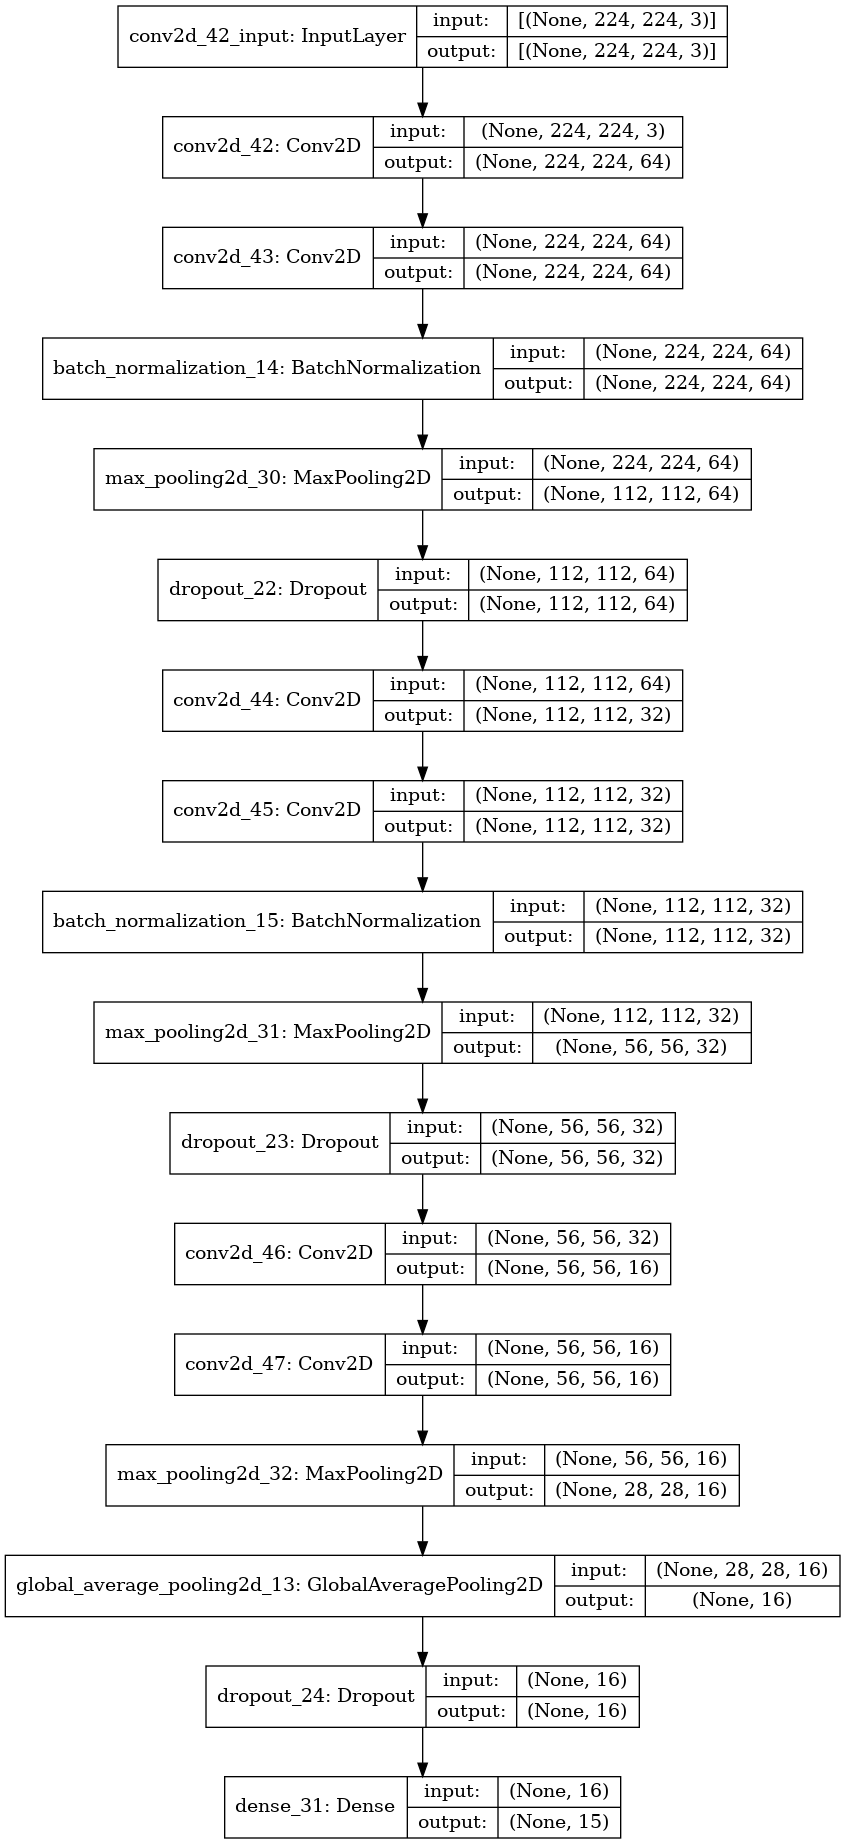

In [107]:
tf.keras.utils.plot_model(model_bndr_cnn, to_file="model_cnn_1.png", show_shapes=True)

In [108]:
model_bndr_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [109]:
epochs = 15
model_bndr_cnn_fit = model_bndr_cnn.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/15
469/469 [==============================] - 78s 164ms/step - loss: 2.7929 - accuracy: 0.2093 - val_loss: 2.8250 - val_accuracy: 0.0713
Epoch 2/15
469/469 [==============================] - 80s 170ms/step - loss: 2.4808 - accuracy: 0.2869 - val_loss: 2.7079 - val_accuracy: 0.0667
Epoch 3/15
469/469 [==============================] - 80s 170ms/step - loss: 2.5063 - accuracy: 0.2353 - val_loss: 2.7101 - val_accuracy: 0.0710
Epoch 4/15
469/469 [==============================] - 80s 171ms/step - loss: 2.4330 - accuracy: 0.2217 - val_loss: 2.7117 - val_accuracy: 0.0667
Epoch 5/15
469/469 [==============================] - 80s 171ms/step - loss: 2.5291 - accuracy: 0.1803 - val_loss: 2.7121 - val_accuracy: 0.0667
Epoch 6/15
469/469 [==============================] - 80s 170ms/step - loss: 2.3148 - accuracy: 0.2523 - val_loss: 2.7198 - val_accuracy: 0.0667
Epoch 7/15
469/469 [==============================] - 79s 169ms/step - loss: 2.2225 - accuracy: 0.2433 - val_loss: 2.7402 - val_ac

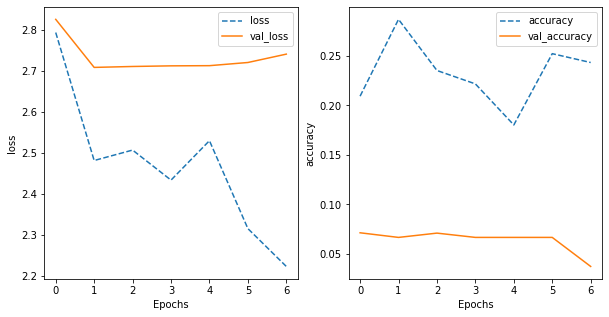

In [110]:
training_plot(['loss', 'accuracy'], model_bndr_cnn_fit)

In [111]:
testAccuracy(model_bndr_cnn)


Test Accuracy: 6.67%



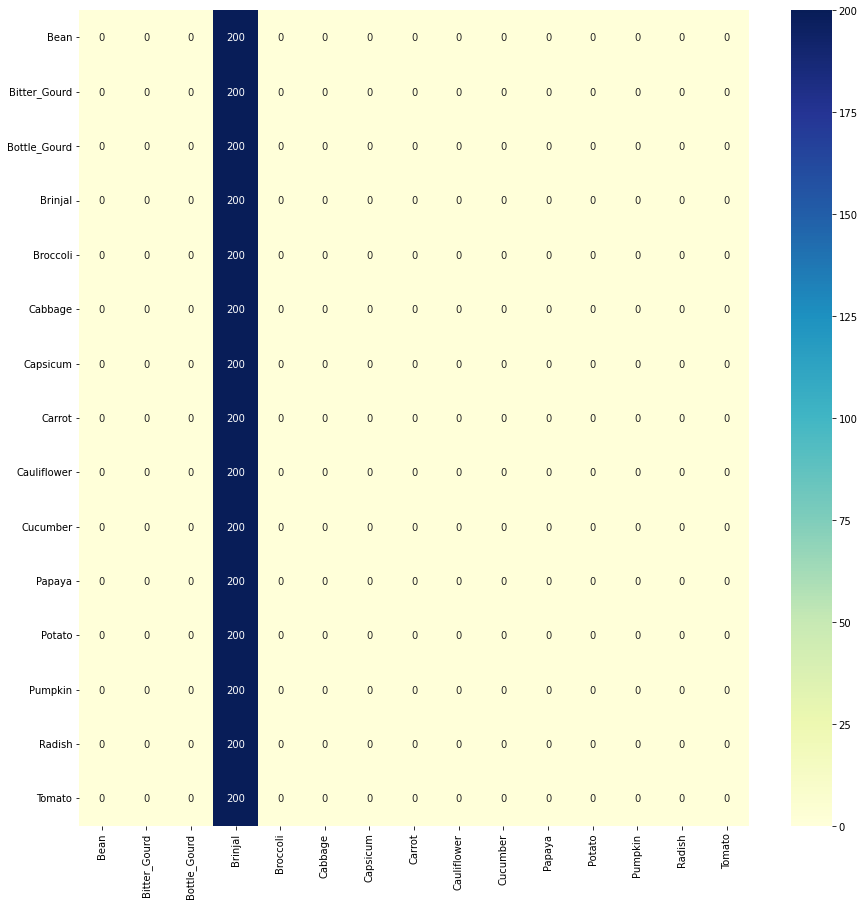

In [112]:
ConfusionMatrix(model_bndr_cnn, test_ds, test_data.class_names)

In [113]:
#Transfer Learning

In [114]:
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [115]:
vgg16_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_14  (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_33 (Dense)             (None, 15)                975       
Total params: 14,748,495
Trainable params: 33,807
Non-trainable params: 14,714,688
_________________________________________________________________


In [116]:
vgg16_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [117]:
history_vgg16 = vgg16_model.fit(train_ds, epochs=20, validation_data=val_ds,callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/20
469/469 [==============================] - 78s 166ms/step - loss: 2.7178 - accuracy: 0.1895 - val_loss: 2.7066 - val_accuracy: 0.0693
Epoch 2/20
469/469 [==============================] - 77s 164ms/step - loss: 2.5489 - accuracy: 0.0790 - val_loss: 2.7079 - val_accuracy: 0.0860
Epoch 3/20
469/469 [==============================] - 77s 163ms/step - loss: 2.5816 - accuracy: 0.0942 - val_loss: 3.3030 - val_accuracy: 0.0667
Epoch 4/20
469/469 [==============================] - 77s 164ms/step - loss: 1.9034 - accuracy: 0.2155 - val_loss: 5.2110 - val_accuracy: 0.0630
Epoch 5/20
469/469 [==============================] - 77s 163ms/step - loss: 1.7941 - accuracy: 0.3456 - val_loss: 5.5391 - val_accuracy: 0.0677
Epoch 6/20
469/469 [==============================] - 77s 163ms/step - loss: 1.7345 - accuracy: 0.3281 - val_loss: 5.5753 - val_accuracy: 0.0697


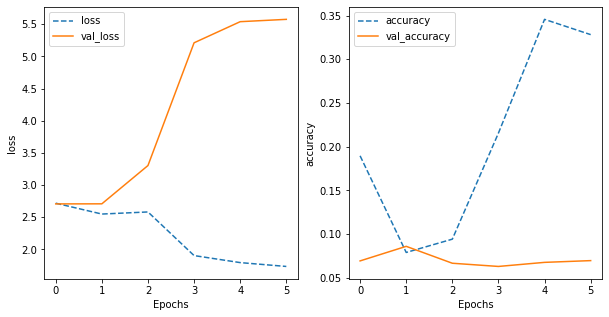

In [118]:
training_plot(['loss', 'accuracy'], history_vgg16)

In [119]:
testAccuracy(vgg16_model)


Test Accuracy: 6.93%



Resnet

In [15]:


pretrained_resnet_model = tf.keras.applications.ResNet50V2(weights='imagenet',
                         include_top=False,
                         input_tensor = (tf.keras.layers.Input(shape=(height,width,3)))
                         )
pretrained_resnet_model.trainable=False
resnet_model = tf.keras.Sequential([
    pretrained_resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])



94683136/94668760 [==============================] - 1s 0us/step


In [121]:
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_15  (None, 2048)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_35 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_36 (Dense)             (None, 15)                975       
Total params: 24,106,767
Trainable params: 541,967
Non-trainable params: 23,564,800
_________________________________________________________________


In [122]:
resnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
history_resnet = resnet_model.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/25
469/469 [==============================] - 56s 114ms/step - loss: 2.6671 - accuracy: 0.6801 - val_loss: 5.1625 - val_accuracy: 0.1267
Epoch 2/25
469/469 [==============================] - 54s 114ms/step - loss: 1.1578 - accuracy: 0.7902 - val_loss: 3.9732 - val_accuracy: 0.2503
Epoch 3/25
469/469 [==============================] - 52s 111ms/step - loss: 0.4819 - accuracy: 0.8749 - val_loss: 2.7180 - val_accuracy: 0.3437
Epoch 4/25
469/469 [==============================] - 53s 113ms/step - loss: 0.2940 - accuracy: 0.9221 - val_loss: 2.9812 - val_accuracy: 0.4663
Epoch 5/25
469/469 [==============================] - 51s 109ms/step - loss: 0.2020 - accuracy: 0.9497 - val_loss: 6.3156 - val_accuracy: 0.3823
Epoch 6/25
469/469 [==============================] - 51s 110ms/step - loss: 0.1469 - accuracy: 0.9619 - val_loss: 7.3163 - val_accuracy: 0.3383
Epoch 7/25
469/469 [==============================] - 51s 109ms/step - loss: 0.1541 - accuracy: 0.9634 - val_loss: 5.8297 - val_ac

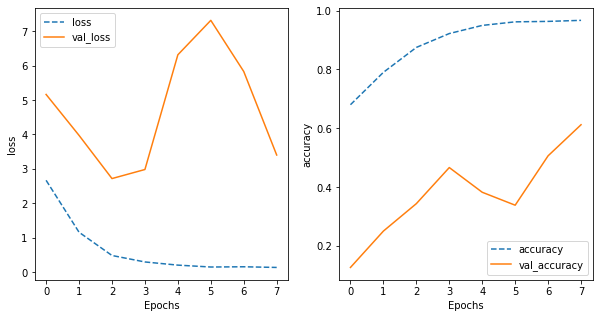

In [124]:
training_plot(['loss', 'accuracy'], history_resnet)

In [125]:
testAccuracy(resnet_model)


Test Accuracy: 34.27%



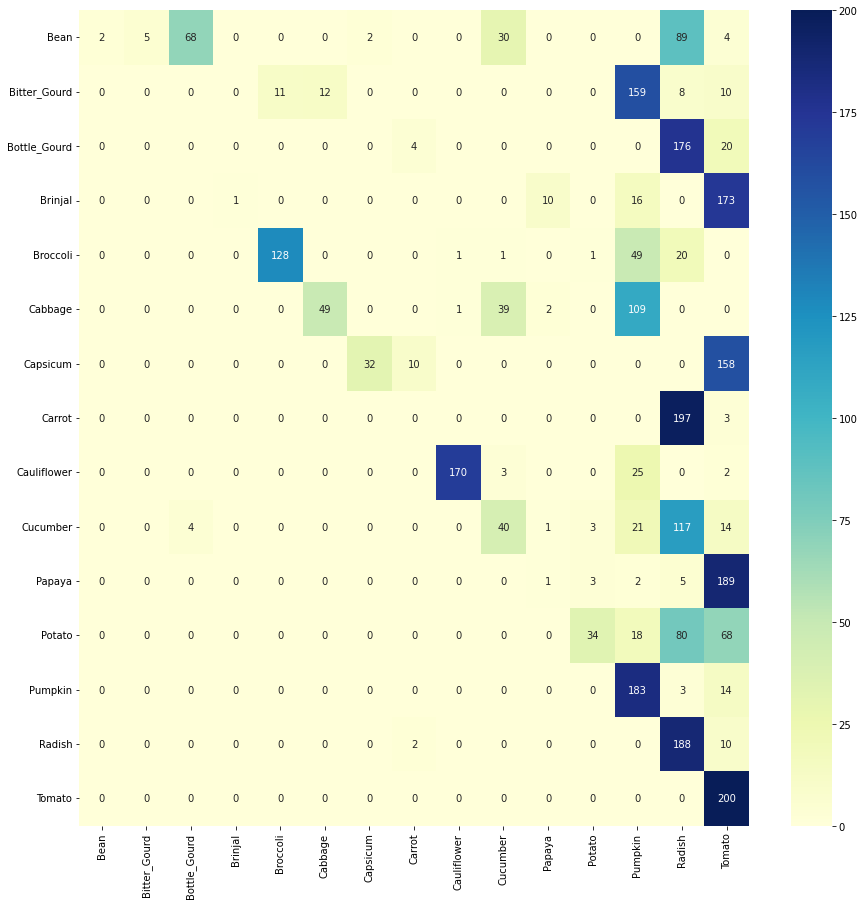

In [126]:
ConfusionMatrix(resnet_model, test_ds, test_data.class_names)

Mobilenet

In [127]:
pretrained_mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_mobilenet_model.trainable=False
mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2056, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [128]:
mobilenet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [129]:
mobilenet_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_16  (None, 1280)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 2056)              2633736   
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              2106368   
_________________________________________________________________
dense_39 (Dense)             (None, 64)                65600     
_________________________________________________________________
dense_40 (Dense)             (None, 15)                975       
Total params: 7,064,663
Trainable params: 4,806,679
Non-trainable params: 2,257,984
____________________________________

In [130]:
history_mobilenet = mobilenet_model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/10
469/469 [==============================] - 41s 82ms/step - loss: 4.7172 - accuracy: 0.7183 - val_loss: 29.9845 - val_accuracy: 0.0667
Epoch 2/10
469/469 [==============================] - 41s 88ms/step - loss: 2.0889 - accuracy: 0.7127 - val_loss: 15.5901 - val_accuracy: 0.0787
Epoch 3/10
469/469 [==============================] - 37s 79ms/step - loss: 1.1166 - accuracy: 0.7518 - val_loss: 9.6990 - val_accuracy: 0.0713
Epoch 4/10
469/469 [==============================] - 38s 81ms/step - loss: 0.6164 - accuracy: 0.8637 - val_loss: 10.8545 - val_accuracy: 0.2120
Epoch 5/10
469/469 [==============================] - 37s 79ms/step - loss: 0.5988 - accuracy: 0.8581 - val_loss: 5.9622 - val_accuracy: 0.2467
Epoch 6/10
469/469 [==============================] - 38s 80ms/step - loss: 0.4704 - accuracy: 0.8908 - val_loss: 8.7170 - val_accuracy: 0.2507
Epoch 7/10
469/469 [==============================] - 37s 79ms/step - loss: 0.1835 - accuracy: 0.9541 - val_loss: 5.2480 - val_accura

In [131]:
history_mobilenet = mobilenet_model.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/25
469/469 [==============================] - 37s 79ms/step - loss: 0.1742 - accuracy: 0.9579 - val_loss: 9.2399 - val_accuracy: 0.3317
Epoch 2/25
469/469 [==============================] - 41s 87ms/step - loss: 0.2263 - accuracy: 0.9532 - val_loss: 8.5716 - val_accuracy: 0.3140
Epoch 3/25
469/469 [==============================] - 37s 80ms/step - loss: 0.1662 - accuracy: 0.9624 - val_loss: 8.1560 - val_accuracy: 0.3330
Epoch 4/25
469/469 [==============================] - 37s 79ms/step - loss: 0.1723 - accuracy: 0.9671 - val_loss: 12.7864 - val_accuracy: 0.2677
Epoch 5/25
469/469 [==============================] - 37s 79ms/step - loss: 0.2429 - accuracy: 0.9547 - val_loss: 6.3733 - val_accuracy: 0.3620
Epoch 6/25
469/469 [==============================] - 38s 80ms/step - loss: 0.2142 - accuracy: 0.9581 - val_loss: 16.4932 - val_accuracy: 0.2713
Epoch 7/25
469/469 [==============================] - 37s 80ms/step - loss: 0.1632 - accuracy: 0.9655 - val_loss: 5.8066 - val_accurac

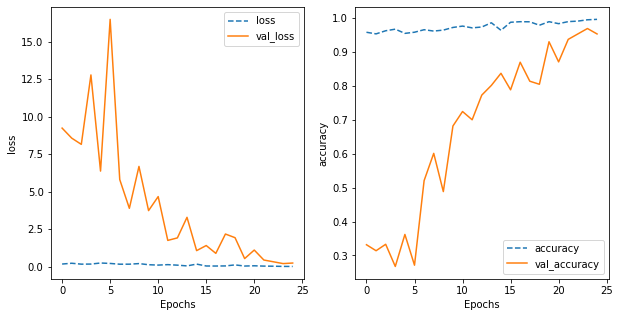

In [132]:
training_plot(['loss', 'accuracy'], history_mobilenet)

In [133]:
testAccuracy(mobilenet_model)


Test Accuracy: 95.60%



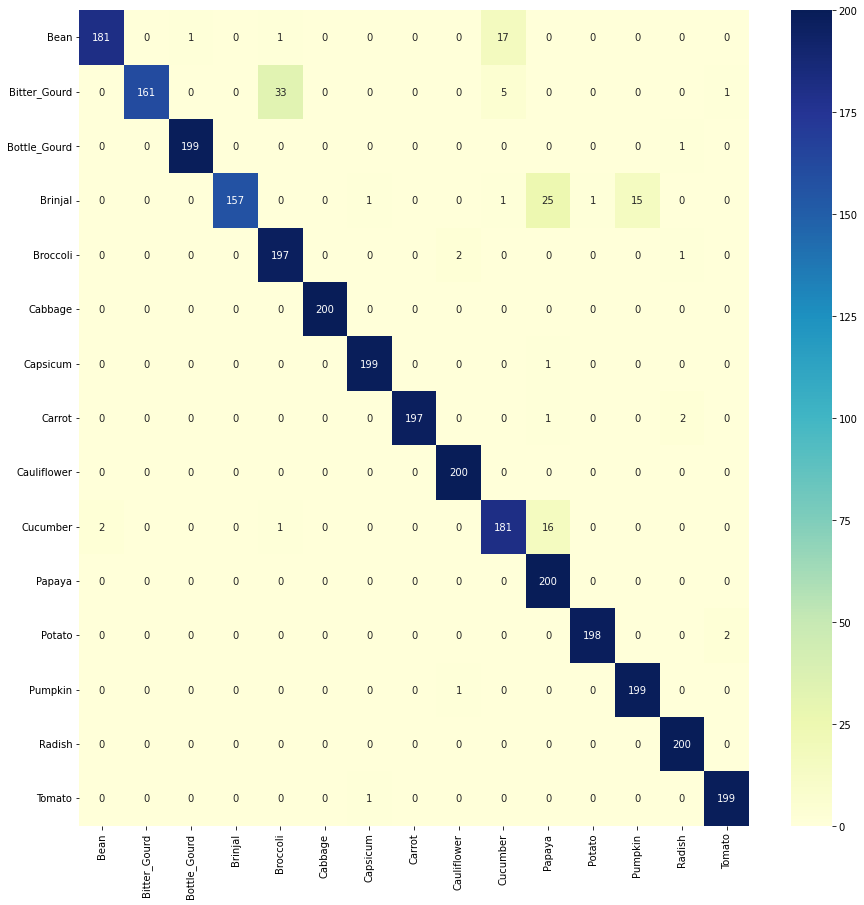

In [134]:
ConfusionMatrix(mobilenet_model, test_ds, test_data.class_names)

Lets try another ResNet 50 again with some more fully connected layers to see if we get better results

In [60]:
pretrained_resnet_model1 = tf.keras.applications.ResNet50V2(weights='imagenet',
                         include_top=False,
                         input_tensor = (tf.keras.layers.Input(shape=(height,width,3)))
                         )
pretrained_resnet_model1.trainable=False
resnet_model1 = tf.keras.Sequential([
    pretrained_resnet_model1,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2056, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(15, activation='softmax')
])



In [61]:
resnet_model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 2056)              4212744   
_________________________________________________________________
dense_54 (Dense)             (None, 1024)              2106368   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_56 (Dense)             (None, 64)               

In [62]:
resnet_model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
history_resnet1 = resnet_model1.fit(train_ds, epochs=35, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/35
469/469 [==============================] - 55s 111ms/step - loss: 7.9397 - accuracy: 0.6995 - val_loss: 38.7738 - val_accuracy: 0.0667
Epoch 2/35
469/469 [==============================] - 52s 110ms/step - loss: 2.5415 - accuracy: 0.6496 - val_loss: 8.5900 - val_accuracy: 0.0667
Epoch 3/35
469/469 [==============================] - 51s 109ms/step - loss: 1.3576 - accuracy: 0.7777 - val_loss: 10.4253 - val_accuracy: 0.1157
Epoch 4/35
469/469 [==============================] - 53s 113ms/step - loss: 1.2636 - accuracy: 0.7507 - val_loss: 10.9752 - val_accuracy: 0.1847
Epoch 5/35
469/469 [==============================] - 51s 110ms/step - loss: 0.9254 - accuracy: 0.8331 - val_loss: 10.1939 - val_accuracy: 0.3283
Epoch 6/35
469/469 [==============================] - 51s 108ms/step - loss: 0.8126 - accuracy: 0.8789 - val_loss: 9.5275 - val_accuracy: 0.2893
Epoch 7/35
469/469 [==============================] - 51s 109ms/step - loss: 0.6487 - accuracy: 0.8511 - val_loss: 5.2144 - va

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/35
469/469 [==============================] - 51s 109ms/step - loss: 0.0276 - accuracy: 0.9950 - val_loss: 0.8208 - val_accuracy: 0.9387
Epoch 29/35
469/469 [==============================] - 51s 109ms/step - loss: 0.0225 - accuracy: 0.9961 - val_loss: 0.2528 - val_accuracy: 0.9697
Epoch 30/35
469/469 [==============================] - 51s 109ms/step - loss: 0.0173 - accuracy: 0.9961 - val_loss: 0.3415 - val_accuracy: 0.9650
Epoch 31/35
469/469 [==============================] - 51s 108ms/step - loss: 0.0165 - accuracy: 0.9963 - val_loss: 0.8319 - val_accuracy: 0.8837
Epoch 32/35
469/469 [==============================] - 51s 108ms/step - loss: 0.0315 - accuracy: 0.9932 - val_loss: 1.5252 - val_accuracy: 0.9400
Epoch 33/35
469/469 [==============================] - 51s 109ms/step - loss: 0.0519 - accuracy: 0.9923 - val_loss: 3.3948 - val_accuracy: 0.8200
Epoch 34/35
469/469 [==============================] - 51s 109ms/step - loss: 0.0716 - accuracy: 0.9871 - val_loss: 1.3574 -

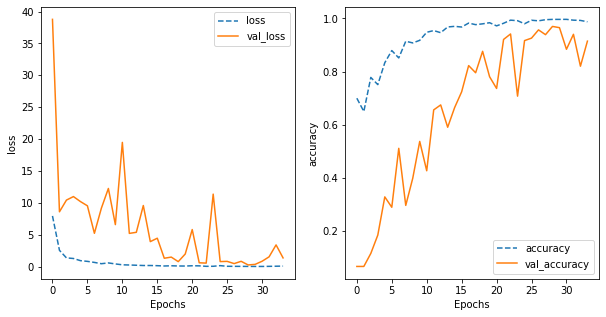

In [64]:
training_plot(['loss', 'accuracy'], history_resnet1)

In [65]:
testAccuracy(resnet_model1)


Test Accuracy: 96.27%



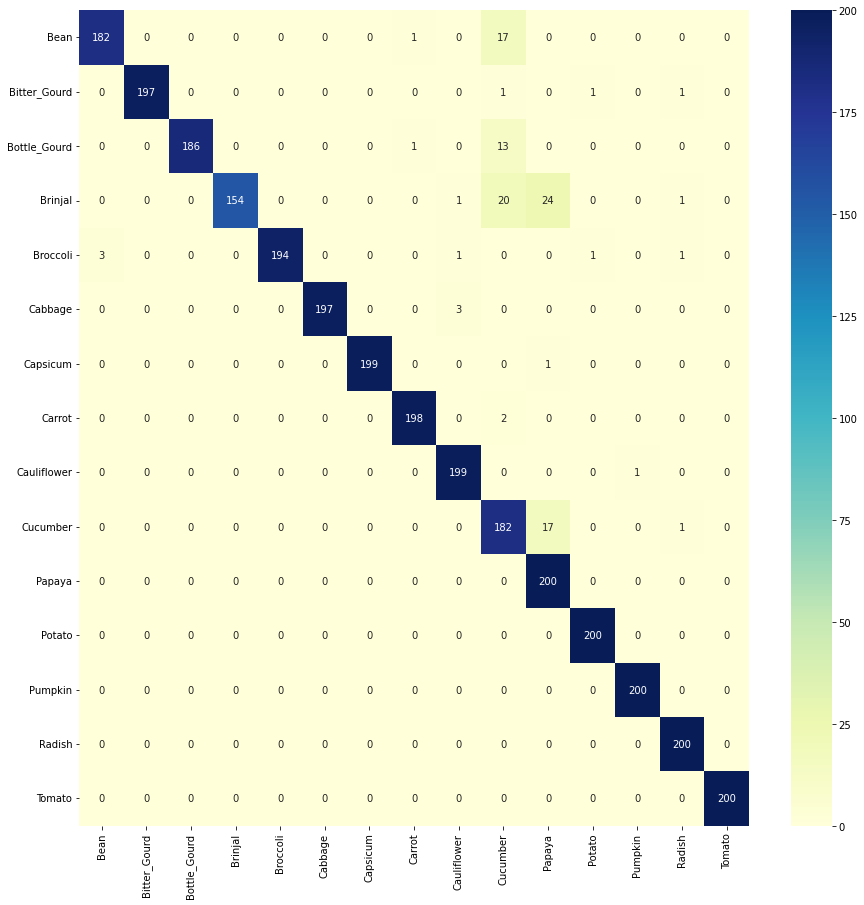

In [67]:
ConfusionMatrix(resnet_model1, test_ds, test_data.class_names)

We can see that mobilenet model and ResNet model 1 can give about 96% accuracy in test data. With a deeper nueral net 
higher accuracy could have been achieved.

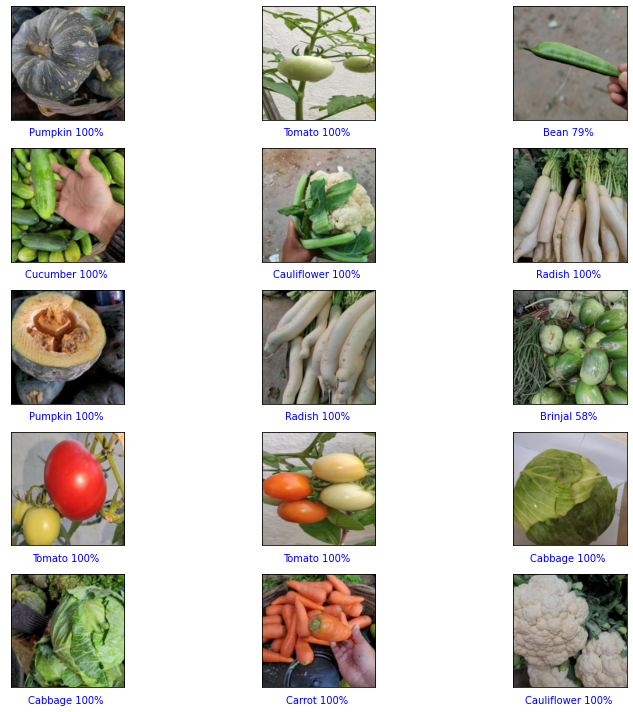

In [70]:
predictions(resnet_model1)

Inference 

For this dataset the best performing model is ResNet and Mobilenet. 